In [118]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.multiclass import OneVsRestClassifier as ovr
from sklearn.svm import SVC
from cv2 import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,SelectPercentile,f_regression
# from sklearn.feature_selection import f_regression
from sklearn import metrics
import math
from sklearn.preprocessing import normalize

In [2]:
def gray_images(images):
    gray_imgs = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray_imgs.append(img)
        
    return gray_imgs    

### Dataset

In [3]:
def get_data(path):
    images = []
    for file in os.listdir(path):
        if file[0]!= '.':
            images.append(cv2.imread(path+"/"+file))
                    
    return images

In [7]:
# faces = get_data('../dataset/faces')
# non_faces = get_data('../dataset/non_faces')

faces = np.load("../dataset/face.npy") 
non_faces = np.load("../dataset/non_face.npy")

N = 1000

X = np.vstack((faces[0:N], non_faces[0:N]))
Y = np.array([1]*N + [0]*N)



x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [8]:
print(x_train.shape)
print(x_test.shape)

(1400, 24, 24)
(600, 24, 24)


### visualize

In [11]:
def display(images):
    for img in images:
        fig = plt.figure(figsize=(0.8,0.8))
        plt.imshow(img)
        plt.show()

In [5]:
def scale(im,scale_percent=0.3):
    im = cv2.resize(im, (100, 100), interpolation = cv2.INTER_AREA)
    return im

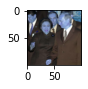

In [6]:
image = cv2.imread("../dataset/1.jpg")
img2 = scale(image)
display([img2])

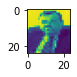

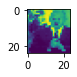

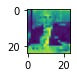

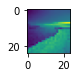

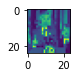

In [12]:
display(x_train[0:5])

### Integral Image

In [13]:
def integral_image(image):
    intgrl_img = np.zeros(image.shape)
    row_sum = np.zeros(image.shape)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            row_sum[x][y] = image[x][y]
            if y != 0:
                row_sum[x][y] += row_sum[x][y-1]
            intgrl_img[x][y] += row_sum[x][y]
            if x != 0:
                intgrl_img[x][y] += intgrl_img[x-1][y]
    
    return intgrl_img
                

In [14]:
sample_image =  np.array([
    [5, 2, 3, 4, 1], 
    [1, 5, 4, 2, 3],
    [2, 2, 1, 3, 4],
    [3, 5, 6, 4, 5],
    [4, 1, 3, 2, 6]])
intgrl_img = integral_image(sample_image)
intgrl_img

array([[ 5.,  7., 10., 14., 15.],
       [ 6., 13., 20., 26., 30.],
       [ 8., 17., 25., 34., 42.],
       [11., 25., 39., 52., 65.],
       [15., 30., 47., 62., 81.]])

### Features

#### define all the 160k features (different size, different position )

In [15]:
def get_features():
    feature = [[1,2],[2,1], [1,3], [2,2]]
    framesize = 24
    features = []
    count = 0
    for i in range(len(feature)):
        sizex = feature[i][0]
        sizey = feature[i][1]
        
        ##size of the feature
        for height in range(sizex,framesize+1,sizex):
            for width in range(sizey,framesize+1,sizey):
                
                ##position of the feature
                for x in range(0,framesize-height+1):
                    for y in range(0,framesize-width+1):
                        features.append([i,x,y,height,width])
                        
    return features

In [16]:
features = get_features()

#### Evaluate 160k features over the train images

In [18]:
def evaluate_feature(feature,image):
    
    if feature[0] == 0:
        _,x,y,height,width = feature
        width //= 2
        white = get_sum(image,x,y,height,width)
        black = get_sum(image,x,y+width,height,width)
        return black-white
    
    if feature[0] == 1:
        _,x,y,height,width = feature
        height //= 2
        black = get_sum(image,x,y,height,width)
        white = get_sum(image,x+height,y,height,width)
        return black - white
    
    if feature[0] == 2:
        _,x,y,height,width = feature
        width //=3
        white = get_sum(image,x,y,height,width) + get_sum(image,x,y+(2*width),height,width)
        black = get_sum(image,x,y+width,height,width)
        return black - white
    
    if feature[0] == 3:
        _,x,y,height,width = feature
        width //= 2
        height //= 2
        white = get_sum(image,x,y,height,width) + get_sum(image,x+height,y+width,height,width)
        black = get_sum(image,x,y+width,height,width) + get_sum(image,x+height,y,height,width)
        return black - white

In [19]:
def get_sum(intgrl_img,x, y, height, width):
    
    x1 = x+height-1
    y1 = y+width-1
    
    if x == 0 and y == 0 :
        corners = [0]*3
    elif x == 0:
        corners = [0, 0, -1*intgrl_img[x1,y-1]]    
    elif y == 0:
        corners = [0, -1*intgrl_img[x-1,y1],0]
    else:
        corners = [intgrl_img[x-1,y-1],-1*intgrl_img[x-1,y1], -1*intgrl_img[x1,y-1]]
    
    corners += [intgrl_img[x1, y1]]
    
    return sum(corners)

In [20]:
def feature_values(images):
    features = get_features()
    res = np.zeros((0,len(features)))
    for img in images:
        temp = []
        intgrl = integral_image(img)
        for feature in features:
            temp.append(evaluate_feature(feature,intgrl))
         
        res = np.hstack((res.reshape(len(temp),-1),np.array(temp).reshape(len(temp),-1)))
    return res

In [24]:
feature_vals = feature_values(x_train)
feature_vals.shape

(134736, 1400)


#### Select best features using sklearn feature selection

In [25]:
best_feature_ind = SelectPercentile(f_regression, percentile=10).fit(feature_vals.T, y_train).get_support(indices=True)
len(best_feature_ind)

13474

In [27]:
new_features_val = np.take(feature_vals, best_feature_ind,axis=0)
new_features = np.take(features,best_feature_ind,axis=0)

### Train the weak_classifiers

In [28]:
def get_weak_classifier(images,labels,feature_vals,T=10):

    weights = np.zeros(len(labels))
    
    ind = np.where(labels==1)[0]
    weights[ind] = 1/(2*len(ind))
    
    ind = np.where(labels==0)[0]
    weights[ind] = 1/(2*len(ind))
    
    selected = []
    weak_classifiers = []
    alphas = []
    
    for t in range(T): 
        min_err = np.inf
        pred_t = None
        min_ind = 0
        p_t = 0
        for i in range(len(feature_vals)):
            if i not in selected:
                p,th = get_threshold(weights,labels,feature_vals[i])
                
                pred = np.zeros(len(feature_vals[i]))
                pred[np.where(p*feature_vals[i] < p*th)[0]] = 1 
                
                err = np.sum(weights[np.where(pred!=labels)[0]])
                if err<min_err:
                    min_err = err.copy()
                    pred_t = pred.copy()
                    p_t = p
                    th_t = th
                    min_ind = i
        
        selected.append(min_ind)
        beta = min_err/(1-min_err)
        
        ind = np.where(pred_t==labels)[0]
        weights[ind] = weights[ind]*beta
        print("Iter t: \nCorrect predictions:",len(ind),"\n")
        
        alphas.append(math.log((1/beta)))
        weak_classifiers.append([p_t,th_t,min_ind,alphas[-1]]) #np.vstack((weak_classifiers,(pred_t*alphas[-1])))
           
    print("Alpha values:", alphas)
    
    th = np.sum(np.array(alphas))/2
    
    return [weak_classifiers,th]    
        

In [29]:
def get_threshold(weights,labels,feature): 
    sort_feat = sorted(zip(feature,weights,labels),key=lambda x:x[0])
    Tp = np.sum(weights[np.where(labels==1)[0]])
    Tn = np.sum(weights[np.where(labels==0)[0]])
    Wn = Wp = p = pos = th = 0
    min_err = np.inf
   
    for f,w,l in sort_feat:
        e = min(Wn+Tp-Wp,Wp+Tn-Wn)
        if e < min_err:
            min_err = e
            th = f
            p = 1 if pos > 0 else -1
        if l==1:
            pos += 1
            Wp += w
        else:
            pos -= 1
            Wn += w
            
    return [p,th]

In [406]:
weak_classifiers,th = get_weak_classifier(x_train,y_train,new_features_val)

Iter t: 
Correct predictions: 1000 

Iter t: 
Correct predictions: 897 

Iter t: 
Correct predictions: 883 

Iter t: 
Correct predictions: 762 

Iter t: 
Correct predictions: 809 

Iter t: 
Correct predictions: 697 

Iter t: 
Correct predictions: 752 

Iter t: 
Correct predictions: 701 

Iter t: 
Correct predictions: 720 

Iter t: 
Correct predictions: 706 

Alpha values: [0.9148397424905754, 1.459670416302822, 2.479204735079772, 3.930034842953307, 6.643302427106876, 10.607653212790442, 17.301940754043176, 27.957784974333265, 45.284513121060634, 73.25493210924901]


### Predict the values using Strong Classifier defined by combining all the weak classifiers

In [31]:
def strong_classifier(weak_classifiers, alpha_th, images,features):
    h = np.zeros(len(images))
    for clf in weak_classifiers:
        p,th,i,alpha = clf
        feature = get_feature_val(images,features[i])
        h[np.where(p*feature < p*th)[0]] += alpha
    
    pred = np.zeros(len(images))
    pred[np.where(h>=alpha_th)] = 1
    
    return pred

In [32]:
def get_feature_val(images,feature):
    f = []
    for img in images:
        f.append(evaluate_feature(feature,integral_image(img)))
    
    return np.array(f)

In [33]:
y_pred = strong_classifier(weak_classifiers,th,x_train,new_features)

In [34]:
metrics.accuracy_score(y_pred,y_train)

0.7514705882352941

In [35]:
y_pred =  strong_classifier(weak_classifiers,th,x_test,new_features)

In [36]:
metrics.accuracy_score(y_pred,y_test)

0.725

## Question 2

### Dataset

In [84]:
def resize(image,dim=(150,150)):
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [85]:
def get_data(path):
    images = []
    labels = []
    for label in os.listdir(path):
        if label[0]!= '.':
            sub_path = path+"/"+label
            for file in os.listdir(sub_path):
                if file[0]!= '.':
                    images.append(resize(cv2.imread(sub_path+"/"+file)))
                    labels.append(label)
                    
    return [images,labels]

In [86]:
path = '../dataset/SUN_data/train'
train_data = get_data(path) 

In [87]:
path = '../dataset/SUN_data/test'
test_data = get_data(path) 

### Training

#### Bag of features

In [88]:
def SIFT_(img):
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img,None)
    
    return des

In [89]:
def get_descriptors(images):
    descriptors = []
    
    for img in images:
        desc = SIFT_(img)
        descriptors.append(desc)
    
    return descriptors

In [90]:
descriptors = get_descriptors(train_data[0])

#### KMeans

In [91]:
def k_means(n, features):
    kmeans = KMeans(n_clusters = n,random_state = 0)
    kmeans.fit(features)
    
    return kmeans

In [144]:
n=400  ## number of clusters
bag_of_features = np.concatenate(descriptors, axis=0).astype('int')
kmeans = k_means(n,bag_of_features)

#### Histogram

In [145]:
def histogram(n,desc,kmeans):
    res = np.zeros((len(desc),n),int)

    for i in range(len(desc)):
        c = kmeans.predict(desc[i].astype(int))
        res[i][c] += 1
            
    return res
    

In [146]:
hist = histogram(n,descriptors,kmeans)

#### TF_IDFs

In [147]:
def get_tf_idfs(hist,dfi,normalise = False):
    tf = hist/np.sum(hist,axis=1, keepdims=True)
    tf_idf = np.multiply(tf,dfi)
    
    if normalise:
        return normalize(tf_idf, axis=0, norm='max')
    
    return tf_idf

In [148]:
dfi = np.sum((hist != 0),axis=0)
N = len(train_data[0])

dfi= np.log(N/dfi)


In [149]:
tf_idfs = get_tf_idfs(hist,dfi)

#### SVM

In [150]:
model = ovr(SVC())
model.fit(tf_idfs,train_data[1])

OneVsRestClassifier(estimator=SVC())

### Testing

#### Bag of features

In [151]:
desc_test = get_descriptors(test_data[0])

#### histogram

In [152]:
hist1 = histogram(n,desc_test,kmeans)

In [153]:
tf_idfs1 = get_tf_idfs(hist1,dfi)

#### Prediction

In [154]:
pred = model.predict(tf_idfs1)
metrics.accuracy_score(pred,test_data[1])

0.4375

In [155]:
metrics.confusion_matrix(pred,test_data[1])

array([[11,  1,  0,  1,  2,  5,  0,  2],
       [ 1, 14,  6,  2,  2,  1,  0,  5],
       [ 0,  0,  5,  2,  0,  0,  1,  2],
       [ 2,  1,  1, 10,  6,  0,  1,  2],
       [ 0,  0,  4,  3,  9,  2,  0,  3],
       [ 4,  1,  1,  2,  0,  9,  9,  2],
       [ 2,  3,  1,  0,  0,  3,  9,  1],
       [ 0,  0,  2,  0,  1,  0,  0,  3]])

### With Normalization

In [156]:
tf_idfs = get_tf_idfs(hist,dfi,normalise = True)

In [157]:
model = ovr(SVC(kernel="linear"))
model.fit(tf_idfs,train_data[1])

OneVsRestClassifier(estimator=SVC(kernel='linear'))

In [158]:
tf_idfs1 = get_tf_idfs(hist1,dfi,normalise = True)

In [159]:
pred = model.predict(tf_idfs1)
metrics.accuracy_score(pred,test_data[1])

0.38125

In [160]:
metrics.confusion_matrix(pred,test_data[1])

array([[ 9,  1,  1,  0,  2,  6,  6,  3],
       [ 0,  9,  2,  1,  0,  2,  0,  1],
       [ 0,  1,  7,  1,  0,  0,  1,  1],
       [ 1,  1,  2, 10,  3,  1,  2,  1],
       [ 2,  4,  4,  3, 11,  4,  0,  4],
       [ 3,  1,  1,  1,  0,  4,  4,  2],
       [ 5,  3,  2,  4,  3,  3,  7,  4],
       [ 0,  0,  1,  0,  1,  0,  0,  4]])

### Experimenting with different clusters

In [162]:
n=400  ## number of clusters
for n in [200, 250, 300, 350]:
    kmeans = k_means(n,bag_of_features)
    hist = histogram(n,descriptors,kmeans)
    
    dfi = np.sum((hist != 0),axis=0)
    N = len(train_data[0])

    dfi= np.log(N/dfi)
    tf_idfs = get_tf_idfs(hist,dfi)
    
    model = ovr(SVC())
    model.fit(tf_idfs,train_data[1])
    
    hist1 = histogram(n,desc_test,kmeans)
    
    tf_idfs1 = get_tf_idfs(hist1,dfi)
    
    pred = model.predict(tf_idfs1)
    print("Accuracy score:",metrics.accuracy_score(pred,test_data[1]))

Accuracy score: 0.4375
Accuracy score: 0.40625
Accuracy score: 0.5
Accuracy score: 0.4625
